# Drop-out experiments

# Imports and Load Individual Models

In [1]:
# basic
import os
import pandas as pd
import re
# cobra
from cobra.io import read_sbml_model
from cobra.flux_analysis import pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from micom import Community
# plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from micom.problems import cooperative_tradeoff

from Scripts.functions import test_medium

In [2]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


# Functions

In [3]:
def change_medium(model, medium_dict, syncom="yes"):
    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    # we only have community models, so we need to adjust the medium suffices
    medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium_dict.items()}

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)

In [4]:
def community_pfba(com_model, medium):
    with model:
        change_medium(com_model, medium)
        try:
            fluxes = com_model.cooperative_tradeoff(pfba=True, fluxes=True).fluxes.transpose()
        except (Infeasible, OptimizationError):
            print(f"Model {com_model.id} is infeasible.")
            return None, None

        growth = fluxes[fluxes.index.str.contains("Growth")].transpose()
        growth = growth[~ growth.index.str.contains("medium")]
        growth.index.name = "model"
        growth = growth["Growth"]
        #print(com_model.id, growth)

        return fluxes, growth

In [5]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x

In [6]:
# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict, frac=1):
    with model:
        change_medium(model, medium_dict)
        try:
            #print(model.medium)
            solution = model.cooperative_tradeoff(fluxes=True, pfba=True, fraction=frac).fluxes.transpose()
            growth = solution[solution.index.str.contains("Growth")].transpose()
            growth = growth[~ growth.index.str.contains("medium")]
            growth.index.name = "model"
            growth = growth["Growth"]
            return growth
        except Infeasible:
            #print(f"Model {model.id} is infeasible with the given medium.")
            return None
        except OptimizationError as e:
            #print(f"OptimizationError for model {model.id}: {e}")
            return None


# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results, save_path=None):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame
    df = df.apply(pd.to_numeric, errors='coerce') # take care of non-numerical values
    # Create a heatmap
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")

    if save_path:
        fig.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Heatmap saved to {save_path}")

    plt.show()
    return df


# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False, save_path=None, average="yes"):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    results = {carbon[3:-2]: {model.id: None for model in model_dict.values()} for carbon in flattened_sources}

    for carbon in carbon_list:
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        # define uptake bound here (this has big impact on how much biomass can be produced)
        # med_dict = {new_medium[i]: medium_uptake_bound for i in range(len(new_medium))}

        #####
        if carbon_only:
            carbon_sources = carbon if isinstance(carbon, list) else [carbon]
            med_dict = {
                met: medium_uptake_bound if met in carbon_sources else 1000
                for met in new_medium}
        else:
            med_dict = {met: medium_uptake_bound for met in new_medium}
        #####

        for model in model_dict.values():
            growth_val = test_medium(model, med_dict)
            if isinstance(growth_val, pd.Series):
                if average=="yes":
                    # average growth
                    if model.id == "C7":
                        growth_val= pd.DataFrame(growth_val).iloc[:, 0].sum()/7
                    else: # drop_out
                        growth_val= pd.DataFrame(growth_val).iloc[:, 0].sum()/6
                else:
                    # total growth
                    growth_val= pd.DataFrame(growth_val).iloc[:, 0].sum()
            results[carbon_key][model.id] = growth_val
            #print(carbon_key, growth_val)
        #print("-----")
    return visualise_heatmap_medium(results, save_path=save_path)

# Medium

In [7]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])

In [16]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

In [17]:
combined_med_wo_bz = medium_combined_krumbach[medium_combined_krumbach['reaction'] != 'EX_bz_e']

In [10]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

In [11]:
ecoplate_short = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon_shortened.csv", sep=";", quotechar='"')
ecoplate_rxns_short = [safe_parse(x) for x in ecoplate_short["reaction"]]

# Create C7 Community Model with MICOM

In [12]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [13]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

# Create Drop-out Communities
From our C7 community we want to exclude one bacterium at a time making it a C6 community

In [14]:
syncoms = {}

for i in range(len(taxonomy)):
    cut_tax = taxonomy.drop(index=taxonomy.index[i])
    name = f"syncom_drop{i+1}"

    com = Community(
        cut_tax.iloc[:, :-1],
        name="synthetic six member bacterial community",
        id=name,
        solver="cplex")

    # Set EX reaction bounds for this syncom
    for rxn in com.reactions.query("^EX_"):
        rxn.lower_bound = -1000  # make exchange freely available

    syncoms[name] = com

S1, S2, S3, S4, S5, S6, S7 = [syncoms[f"syncom_drop{i+1}"] for i in range(7)]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [15]:
all_models = {**syncoms, 'C7_Community': syncom}

# Growth for all drop-out syncoms

In [18]:
# Include full 7-member community
growth_data = {}

for name, syncom in all_models.items():
    _, growth = community_pfba(syncom, medium_combined_krumbach)
    if growth is not None:
        growth_data[name] = growth

# Combine into DataFrame
growth_df = pd.DataFrame(growth_data).transpose()

epsilon = 1e-6
growth_df = growth_df.applymap(lambda x: 0 if abs(x) < epsilon else x)
# sort to put full community on top
growth_df = growth_df.sort_index(key=lambda x: x.str.replace("C7_Community", "0"), axis=0)

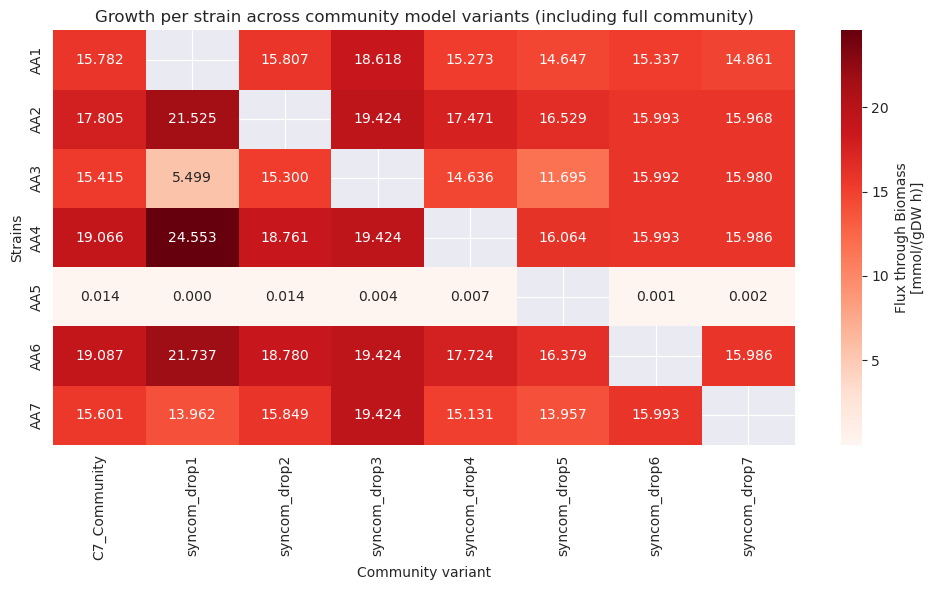

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    growth_df.T,  # Transpose the DataFrame
    fmt=".3f",
    annot=True,
    cmap="Reds",
    cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'}
)
plt.title("Growth per strain across community model variants (including full community)")
plt.xlabel("Community variant")  # flipped axes
plt.ylabel("Strains")            # flipped axes
plt.tight_layout()
#plt.savefig("../Figures/drop_outs_growth_transposed.svg", format="svg", bbox_inches="tight")
plt.show()


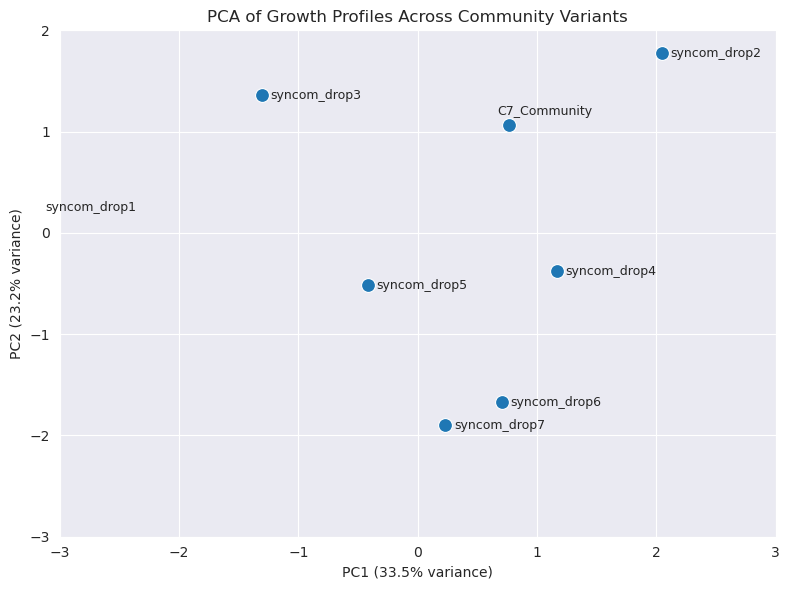

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardise the data
scaler = StandardScaler()
growth_df_filled = growth_df.fillna(0)
scaled_growth = scaler.fit_transform(growth_df_filled)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_growth)

# Create df for PCA result
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=growth_df.index)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)

# Annotate each point with the community name
for name, row in pca_df.iterrows():
    if name != "C7_Community":
        plt.text(row["PC1"] + 0.07, row["PC2"]-0.04, name, fontsize=9)
    else:
        plt.text(row["PC1"] + -0.1, row["PC2"]+0.1, name, fontsize=9)

# Add variance explained info
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100
plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")

plt.title("PCA of Growth Profiles Across Community Variants")
plt.xlim(-3, 3)
plt.ylim(-3, 2)
plt.grid(True)
plt.tight_layout()
plt.savefig("../Figures/drop_outs_growth_pca.svg", format="svg", bbox_inches="tight")
plt.show()

# Substrate Utilisation (BIOLOG Ecoplate)

def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):

In [ ]:
res_df_total = create_medium(ecoplate_rxns_short, m9_rxn, all_models, 1000, save_path="../Figures/drop_outs_ecoplate_total.svg", average="no")
# takes around 9min

[07/22/25 12:42:18] WARNING  solver encountered an error infeasible                                 ]8;id=414587;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=657056;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:19] WARNING  solver encountered an error infeasible                                 ]8;id=849090;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=624737;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:20] WARNING  solver encountered an error infeasible                                 ]8;id=916527;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=863827;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=735957;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=289178;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:21] WARNING  solver encountered an error infeasible                                 ]8;id=252270;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=417220;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=172946;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=815270;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:22] WARNING  solver encountered an error infeasible                                 ]8;id=165397;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=733043;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:23] WARNING  solver encountered an error infeasible                                 ]8;id=216326;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=690966;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=654197;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=766515;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:24] WARNING  solver encountered an error infeasible                                 ]8;id=683815;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=985666;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=645656;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=13600;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:25] WARNING  solver encountered an error infeasible                                 ]8;id=610906;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=328896;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=37385;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=999419;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:26] WARNING  solver encountered an error infeasible                                 ]8;id=230847;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=985291;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:42:27] WARNING  solver encountered an error infeasible                                 ]8;id=573096;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=880912;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=950889;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=594929;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:13] WARNING  solver encountered an error infeasible                                 ]8;id=416909;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=262201;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=748438;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=203672;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:14] WARNING  solver encountered an error infeasible                                 ]8;id=59249;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=517772;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=297126;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=822682;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:51] WARNING  solver encountered an error aborted                                    ]8;id=329586;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=631334;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error aborted                                    ]8;id=111345;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=660225;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:52] WARNING  solver encountered an error infeasible                                 ]8;id=154251;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=140172;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:53] WARNING  solver encountered an error infeasible                                 ]8;id=71039;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=880216;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=703236;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=42340;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:54] WARNING  solver encountered an error infeasible                                 ]8;id=767154;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=588916;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:55] WARNING  solver encountered an error infeasible                                 ]8;id=647848;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=941901;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=790599;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=229931;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:56] WARNING  solver encountered an error infeasible                                 ]8;id=702734;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=459848;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=811023;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=9309;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:57] WARNING  solver encountered an error infeasible                                 ]8;id=360071;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=79562;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:58] WARNING  solver encountered an error infeasible                                 ]8;id=642475;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=319185;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=822022;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=225941;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:43:59] WARNING  solver encountered an error infeasible                                 ]8;id=963441;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=897407;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/22/25 12:44:00] WARNING  solver encountered an error infeasible                                 ]8;id=580708;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=989001;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

                    WARNING  solver encountered an error infeasible                                 ]8;id=352797;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=408091;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

Heatmap saved to ../Figures/drop_outs_ecoplate.svg


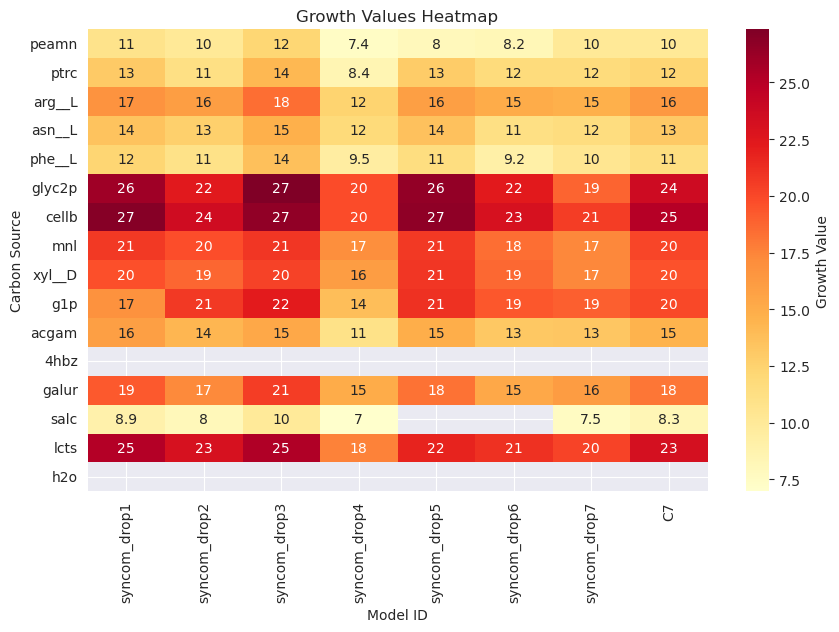

In [21]:
res_df_avg = create_medium(ecoplate_rxns_short, m9_rxn, all_models, 1000, save_path="../Figures/drop_outs_ecoplate.svg", average="yes")

# Combine Heatmaps

In [22]:
growth_with_total = growth_df.copy()

# First calculate the raw sum
growth_with_total["Total"] = growth_with_total.sum(axis=1)

# Adjust Total based on the index
def adjust_total(row):
    if "drop" in row.name:
        return row["Total"] / 6
    elif row.name == "C7_Community":
        return row["Total"] / 7
    else:
        return row["Total"]  # Leave unchanged if none of the above

# Apply the adjustment
growth_with_total["Total"] = growth_with_total.apply(adjust_total, axis=1)


In [23]:
import numpy as np
# Create a mask for the last row ("Total")
mask_top = np.zeros_like(growth_with_total.T, dtype=bool)
mask_top[-1, :] = True  # mask the last row to avoid color distortion

In [24]:
# Custom axis labels
custom_labels_y = ["C7", "C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu"]
custom_labels_x = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community mean"]
#metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]
metab_axis = ["Phenylethylamine", "Putrescine", "L-arginine", "Asparagine", "Phenylalanine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "Galacturonic acid", "2-Hydroxy-benzoic acid", "Lactose", "Water (Control)"]

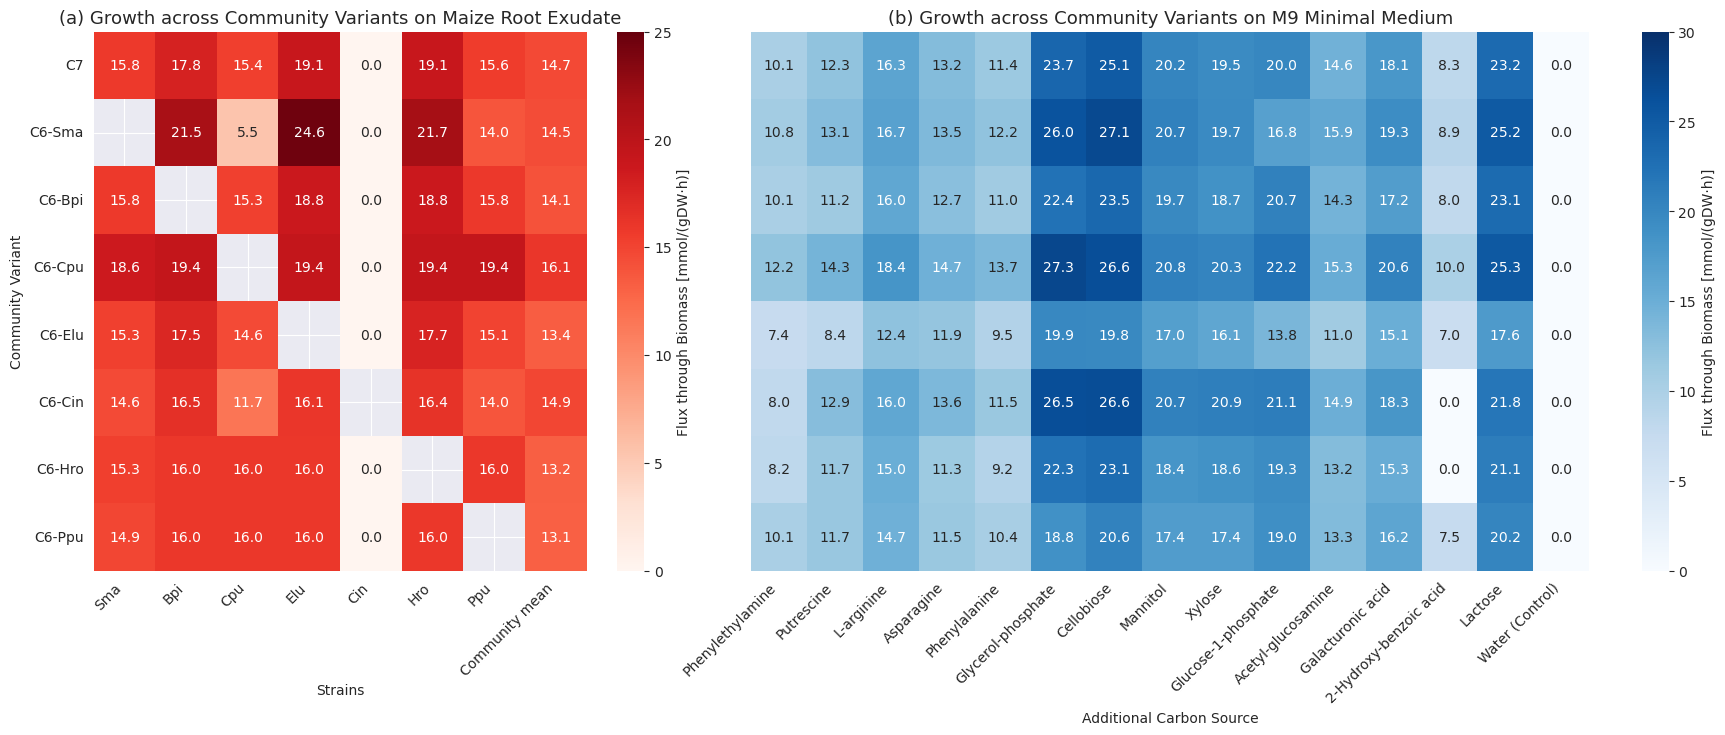

In [27]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(22, 7),
    sharey=True,
    gridspec_kw={'width_ratios': [1, 1.7]}
)

vmin = 0
vmax = 45
color_map1 = "Reds"
color_map2 = "Blues"

# --- First heatmap: Growth ---
sns.heatmap(
    growth_with_total,
    ax=ax1,
    cmap=color_map1,
    annot=True,
    fmt=".1f",
    vmin=0,
    vmax=25,
    cbar=True,
    cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'}
)
ax1.set_ylabel("Community Variant")
ax1.set_xlabel("Strains")
ax1.set_title("Growth across Community Variants dependent on medium and carbon sources", fontsize=14)
ax1.set_xticklabels(custom_labels_x, rotation=45, ha="right")
ax1.set_yticklabels(custom_labels_y, ha="right")

# --- Second heatmap: Metabolite Uptake ---
res_df_clean = res_df_avg[[res_df_avg.columns[-1]] + list(res_df_avg.columns[:-1])]
res_df_clean = res_df_clean.drop(index="4hbz", errors="ignore").fillna(0)
res_df_clean_T = res_df_clean.T

heatmap = sns.heatmap(
    res_df_clean_T,
    ax=ax2,
    cmap=color_map2,
    vmin=0,
    vmax=30,
    annot=True,
    fmt=".1f",
    cbar=True,
    cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'}
)
ax2.set_xlabel("Additional Carbon Source")
#ax2.set_title("Metabolite Uptake across Community Variants", fontsize=14)
ax2.set_xticklabels(metab_axis, rotation=45, ha="right")
ax2.set_yticklabels(custom_labels_y, ha="right")  # Y is shared with ax1

# --- Shared colorbar ---
#cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
#fig.colorbar(heatmap.get_children()[0], cax=cbar_ax, label="Flux through Biomass\n[mmol/(gDW·h)]")

# --- Global super title ---
#fig.suptitle("Growth across Community Variants on", fontsize=16, fontweight='bold', y=0.98, x=0.42)

# --- Individual titles for each subplot ---
ax1.set_title("(a) Growth across Community Variants on Maize Root Exudate", fontsize=13)
ax2.set_title("(b) Growth across Community Variants on M9 Minimal Medium", fontsize=13)

# --- Layout ---
#plt.tight_layout(rect=[0, 0, 0.92, 1])
fig.subplots_adjust(wspace=0.05)

# --- Save & Show ---
plt.savefig("../Figures/combined_heatmap.svg", format="svg", bbox_inches="tight")
plt.show()


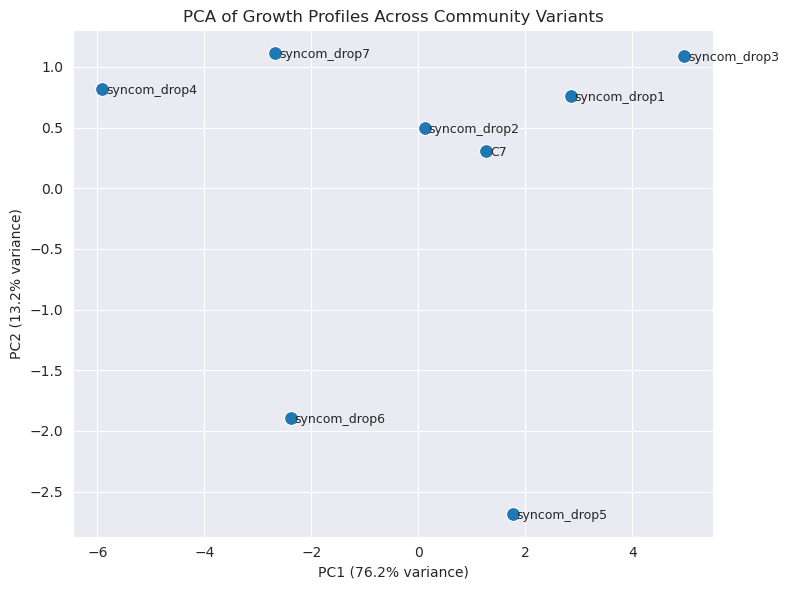

In [26]:
# Standardise the data
scaler = StandardScaler()
growth_df_filled = res_df_clean.T.fillna(0)
scaled_growth = scaler.fit_transform(growth_df_filled)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_growth)

# Create df for PCA result
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=res_df_clean.T.index)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)

# Annotate each point with the community name
for name, row in pca_df.iterrows():
    if name != "C7_Community":
        plt.text(row["PC1"] + 0.07, row["PC2"]-0.04, name, fontsize=9)
    else:
        plt.text(row["PC1"] + -0.1, row["PC2"]+0.1, name, fontsize=9)

# Add variance explained info
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100
plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")

plt.title("PCA of Growth Profiles Across Community Variants")
#plt.xlim(-3, 3)
#plt.ylim(-3, 2)
plt.grid(True)
plt.tight_layout()
#plt.savefig("../Figures/drop_outs_ecoplate_pca.svg", format="svg", bbox_inches="tight")
plt.show()